In [ ]:
# pandas==1.3.3

In [2]:
import time
from tqdm import tqdm_notebook as tqdm
import os
import random
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
from IPython.display import display
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import torch
import tensorflow as tf

In [3]:
# アメリカンフットボールプレーヤのPayton ManningのWikiアクセス数
df = pd.read_csv('http://logopt.com/data/peyton_manning.csv')
display(df.head())
display(df.tail())
print(df.dtypes)
print(df.shape)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


ds     object
y     float64
dtype: object
(2905, 2)


In [4]:
df['ds'] = pd.to_datetime(df['ds'])
print(df.dtypes)

ds    datetime64[ns]
y            float64
dtype: object


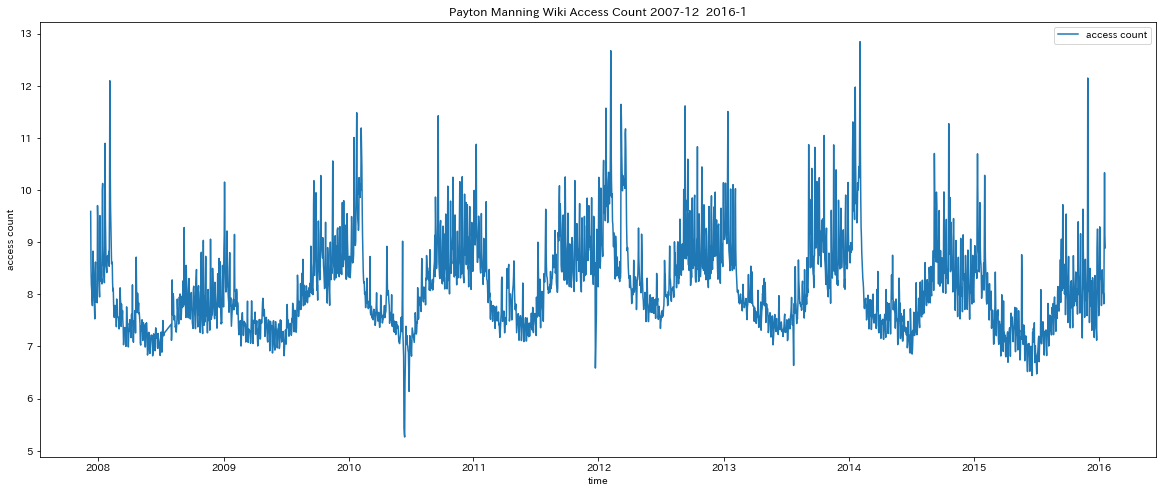

In [5]:
# グラフ表示
fig = plt.figure(figsize=(20, 8))

plt.title("Payton Manning Wiki Access Count 2007-12  2016-1")
plt.xlabel("time")
plt.ylabel("access count")

plt.plot(df["ds"], df["y"], label="access count")
plt.legend()
plt.show()

## シード値の固定

In [6]:
SEED = 42

torch.manual_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

### Merlion

In [7]:
from merlion.utils import TimeSeries
from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster

In [8]:
start_merlion = time.time()

In [9]:
### 交差検証
FOLD = 5
cross_rmse_merlion = []

tscv = TimeSeriesSplit(n_splits=FOLD, test_size=90)

# 日時データをindexに変換
X = copy.deepcopy(df)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):

    train, test = X.iloc[train_index], X.iloc[test_index]

    model = DefaultForecaster(DefaultForecasterConfig())

    # データ変換
    train_ts = TimeSeries.from_pd(train.set_index("ds"))
    test_ts = TimeSeries.from_pd(test.set_index("ds"))

    # 学習
    model.train(train_data=train_ts)

    # 予測データの作成
    pred_merlion, test_err_merlion = model.forecast(time_stamps=test_ts.time_stamps)

    pred_merlion = pred_merlion.to_pd()

    score = np.sqrt(mean_squared_error(test["y"], pred_merlion))
    print(f"{fold} RMSE {score}")

    cross_rmse_merlion.append(score)

print(f"CROSS_RMSE {np.mean(cross_rmse_merlion)}")

0 RMSE 0.934592432240609
1 RMSE 1.2889941734860686
2 RMSE 0.388595149290967
3 RMSE 0.7980016535238239
4 RMSE 0.6990518925540717
CROSS_RMSE 0.8218470602191081


In [10]:
time_merlion = time.time() - start_merlion

### Prophet

In [11]:
from fbprophet import Prophet

In [12]:
start_prophet = time.time()

In [13]:
### 交差検証
FOLD = 5
cross_rmse_prophet = []

tscv = TimeSeriesSplit(n_splits=FOLD, test_size=90)

# 日時データをindexに変換
X = copy.deepcopy(df)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):

    train, test = X.iloc[train_index], X.iloc[test_index]

    # モデルの作成
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True)

    # 学習
    model.fit(train)

    # 予測データの作成
    pred = model.predict(test)
    pred_prophet = pred["yhat"]

    score = np.sqrt(mean_squared_error(test["y"], pred_prophet))
    print(f"{fold} RMSE {score}")

    cross_rmse_prophet.append(score)

print(f"CROSS_RMSE {np.mean(cross_rmse_prophet)}")

0 RMSE 0.5474948116417262
1 RMSE 0.5237987723436899
2 RMSE 0.40175956155830167
3 RMSE 0.3339674222738705
4 RMSE 0.6895171487289081
CROSS_RMSE 0.4993075433092993


In [14]:
time_prophet = time.time() - start_prophet

### Sktime

In [15]:
from sktime.forecasting.all import *

In [16]:
start_sktime = time.time()

In [17]:
### 交差検証
FOLD = 5
cross_rmse_sktime = []

tscv = TimeSeriesSplit(n_splits=FOLD, test_size=90)

# 日時データをindexに変換
X = copy.deepcopy(df)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):

    train, test = X.iloc[train_index], X.iloc[test_index]

    # 学習
    model = ThetaForecaster(sp=len(test))
    model.fit(train["y"])

    fh = ForecastingHorizon(test.index, is_relative=False)

    # 予測データの作成
    pred_sktime = model.predict(fh)

    score = np.sqrt(mean_squared_error(test["y"], pred_sktime))
    print(f"{fold} RMSE {score}")

    cross_rmse_sktime.append(score)

print(f"CROSS_RMSE {np.mean(cross_rmse_sktime)}")

0 RMSE 0.5681174132001073
1 RMSE 0.9714290493152103
2 RMSE 0.41541750187681675
3 RMSE 0.7989632631199044
4 RMSE 0.9043241366350266
CROSS_RMSE 0.7316502728294131


In [18]:
time_sktime = time.time() - start_sktime

### LSTM-Pytorch

In [19]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [20]:
# 時系列データの作成関数
def sliding_windows(data, seq_length , train):
    if train:
        x = []
        y = []
        for i in range(len(data)-seq_length*2):
            _x = data.iloc[i:(i+seq_length)]
            _y = data.iloc[i+(seq_length*2)]
            x.append(_x)
            y.append(_y)
        return np.array(x).reshape(len(x), -1, 1), np.array(y).reshape(-1,1)
    else:
        x = []
        for i in range(len(data)-seq_length+1):
            _x = data[i:(i+seq_length)].values
            x.append(_x)
        return np.array(x)

In [21]:
### 学習モデル
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        h_1 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device))
        c_1 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device))
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
        y = hn.view(-1, self.hidden_size)
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        out = self.fc(final_state)
        return out

In [22]:
seq_length = 12

X, y = sliding_windows(df["y"], seq_length, True)

In [23]:
# 学習用パラメータ
num_epochs = 300
learning_rate = 1e-3
input_size = X.shape[-1]
hidden_size = 64 # 512
num_layers = 12 # 3
num_classes = 1 # 1
batch_size = 16

In [24]:
# 学習モデルの作成
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [25]:
start_lstm_torch = time.time()

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, loss: 68.27299 valid loss:  71.49181 
Epoch: 100, loss: 0.73358 valid loss:  0.33627 
Epoch: 200, loss: 0.73139 valid loss:  0.35829 


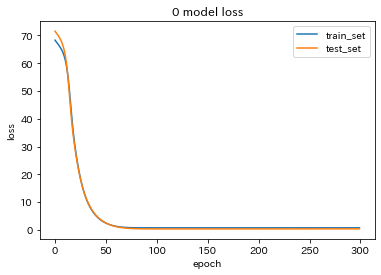

0 RMSE 0.5986557006835938


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, loss: 0.71813 valid loss:  0.66997 
Epoch: 100, loss: 0.71820 valid loss:  0.67984 
Epoch: 200, loss: 0.71790 valid loss:  0.68020 


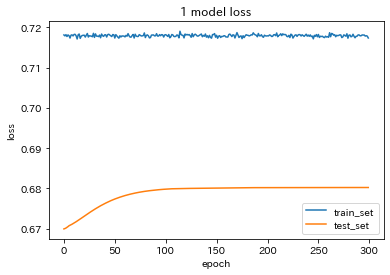

1 RMSE 0.8247706890106201


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, loss: 0.71695 valid loss:  1.27893 
Epoch: 100, loss: 0.71612 valid loss:  1.26326 
Epoch: 200, loss: 0.71666 valid loss:  1.25656 


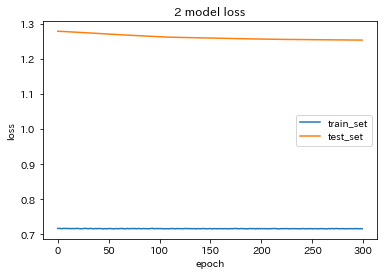

2 RMSE 1.1196686029434204


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, loss: 0.73391 valid loss:  0.44486 
Epoch: 100, loss: 0.73323 valid loss:  0.44258 
Epoch: 200, loss: 0.73348 valid loss:  0.44130 


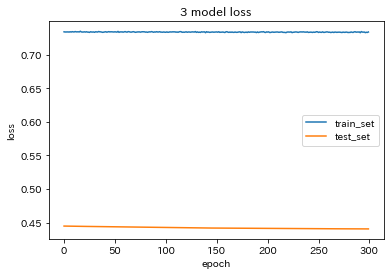

3 RMSE 0.6638040542602539


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, loss: 0.72385 valid loss:  0.61654 
Epoch: 100, loss: 0.72371 valid loss:  0.61662 
Epoch: 200, loss: 0.72364 valid loss:  0.61666 


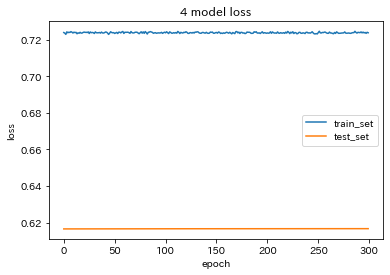

4 RMSE 0.7852904200553894
CROSS_RMSE 0.7984379529953003


In [26]:
### 交差検証
FOLD = 5
cross_rmse_lstm_torch = []

tscv = TimeSeriesSplit(n_splits=FOLD, test_size=90)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):

    loss_list = []
    val_loss_list =[]

    X_train = Variable(torch.Tensor(np.array(X[train_index])))
    y_train = Variable(torch.Tensor(np.array(y[train_index])))
    X_test = Variable(torch.Tensor(np.array(X[test_index])))
    y_test = Variable(torch.Tensor(np.array(y[test_index])))


    for epoch in tqdm(range(num_epochs)): 
        lstm.train()
        outputs = lstm(X_train.to(device))
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, y_train.to(device))
        
        loss.backward()
        
        optimizer.step()
        
        #Evaluate on test     
        lstm.eval()
        valid = lstm(X_test.to(device))
        val_loss = criterion(valid, y_test.to(device))
        scheduler.step(val_loss)

        loss_list.append(loss)
        val_loss_list.append(val_loss)
        
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),val_loss.cpu().item()))

    plt.title(f'{fold} model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label="train_set")
    plt.plot(val_loss_list, label="test_set")
    plt.legend()
    plt.show()

    # 予測
    pred_lstm_torch = lstm(X_test.to(device))
    pred_lstm_torch = pred_lstm_torch.cpu().detach().numpy()

    score = np.sqrt(mean_squared_error(y_test, pred_lstm_torch))
    print(f"{fold} RMSE {score}")

    cross_rmse_lstm_torch.append(score)

print(f"CROSS_RMSE {np.mean(cross_rmse_lstm_torch)}")

In [27]:
time_lstm_torch = time.time() - start_lstm_torch

## LSTM-Keras

In [28]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [29]:
# ネットワークの構築
model = Sequential() # Sequentialモデル

model.add(LSTM(50, batch_input_shape=(None, seq_length, 1))) # LSTM 50層
model.add(Dense(1)) # 出力次元数は1

#コンパイル
model.compile(loss='mean_squared_error', optimizer=Adam() , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [30]:
print(X.shape, y.shape)

(2881, 12, 1) (2881, 1)


In [31]:
start_lstm_keras = time.time()

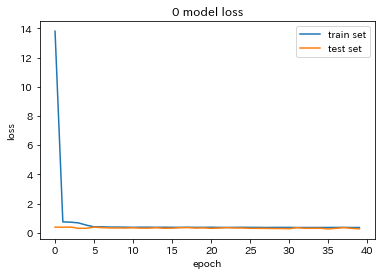

0 RMSE 0.5162700853822174


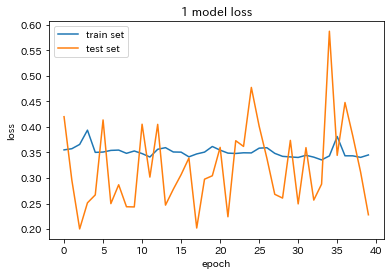

1 RMSE 0.4774951598182519


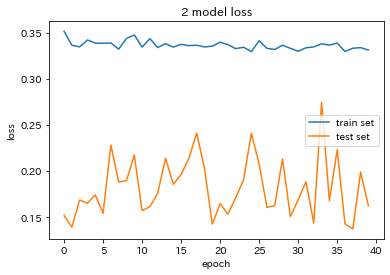

2 RMSE 0.4028385104320866


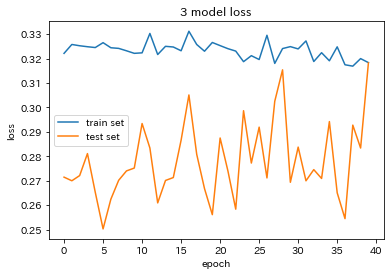

3 RMSE 0.5640908947219808


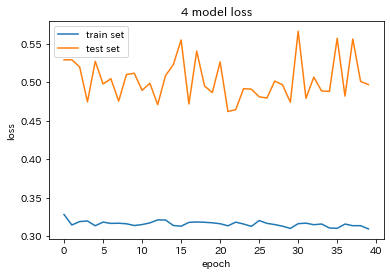

4 RMSE 0.7047805315459569
CROSS_RMSE 0.5330950363800987


In [32]:
# 学習用パラメータ
batch_size = 20
n_epoch = 40

### 交差検証
FOLD = 5
cross_rmse_lstm_keras = []

tscv = TimeSeriesSplit(n_splits=FOLD, test_size=90)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 学習
    hist = model.fit(X_train, y_train,
                    epochs=n_epoch,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    batch_size=batch_size)

    # 損失値(Loss)の遷移のプロット
    plt.plot(hist.history['loss'],label="train set")
    plt.plot(hist.history['val_loss'],label="test set")
    plt.title(f'{fold} model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    pred_lstm_keras = model.predict(X_test)

    score = np.sqrt(mean_squared_error(y_test, pred_lstm_keras))
    print(f"{fold} RMSE {score}")

    cross_rmse_lstm_keras.append(score)

print(f"CROSS_RMSE {np.mean(cross_rmse_lstm_keras)}")

In [33]:
time_lstm_keras = time.time() - start_lstm_keras

### lightGBM



In [34]:
import lightgbm as lgbm

In [35]:
# 元のデータを残すため、別途コピー
df_lag = df.copy()

In [36]:
# 時系列特徴量の作成
df_lag["year"]  = df_lag["ds"].dt.year
df_lag["month"] = df_lag["ds"].dt.month
df_lag["day"]  = df_lag["ds"].dt.day
df_lag["dayofweek"] = df_lag["ds"].dt.dayofweek

In [37]:
# ラグの作成 簡単に1週間と1ヶ月で作成
for i in [7, 30]:
    df_lag[f"shift{i}"] = df_lag["y"].shift(i)

# 差分の作成
for i in [7, 30]:
    df_lag[f"deriv{i}"] = df_lag[f"shift{i}"].diff(i)

# 移動平均の作成
for i in [7, 30]:
    df_lag[f"mean{i}"] = df_lag[f"shift{i}"].rolling(12).mean()

# 中央値、最大値、最小値の作成
for i in [7, 30]:
    df_lag[f"median{i}"] = df_lag[f"shift{i}"].rolling(12).median()

for i in [7, 30]:
    df_lag[f"max{i}"] = df_lag[f"shift{i}"].rolling(12).max()

for i in [7, 30]:
    df_lag[f"min{i}"] = df_lag[f"shift{i}"].rolling(12).min()

In [38]:
# NaN部分を削除
df_lag = df_lag[41:]

In [39]:
# ds列をindexにして説明変数から除外
df_lag = df_lag.set_index("ds")

In [40]:
start_lgbm = time.time()

In [41]:
### 交差検証

FOLD = 5

cross_rmse_lgbm = []

tscv = TimeSeriesSplit(n_splits=FOLD, test_size=90)

X = df_lag.drop("y", axis=1).reset_index(drop=True)
y = df_lag["y"].reset_index(drop=True)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 学習
    model = lgbm.LGBMRegressor()
    model.fit(X_train, y_train)

    # 予測データの作成
    pred_lgbm = model.predict(X_test)

    score = np.sqrt(mean_squared_error(y_test, pred_lgbm))
    print(f"{fold} RMSE {score}")

    cross_rmse_lgbm.append(score)

print(f"CROSS_RMSE {np.mean(cross_rmse_lgbm)}")

0 RMSE 0.5181829606809563
1 RMSE 0.39159050487578206
2 RMSE 0.40106205424817953
3 RMSE 0.3310192560640644
4 RMSE 0.683346704646242
CROSS_RMSE 0.46504029610304476


In [42]:
time_lgbm = time.time() - start_lgbm

### 評価結果 比較

In [43]:
pd.DataFrame(
    [
        ["Merlion", np.mean(cross_rmse_merlion), time_merlion],
        ["Prophet", np.mean(cross_rmse_prophet), time_prophet],
        ["Sktime", np.mean(cross_rmse_sktime), time_sktime],
        ["LSTM Pytorch", np.mean(cross_rmse_lstm_torch), time_lstm_torch],
        ["LSTM Keras", np.mean(cross_rmse_lstm_keras), time_lstm_keras],
        ["LightGBM", np.mean(cross_rmse_lgbm), time_lgbm],
    ],
    columns = ["モデル", "CROSS_RMSE", "処理時間"]
).sort_values("CROSS_RMSE").reset_index(drop=True)

,モデル,CROSS_RMSE,処理時間
0,LightGBM,0.465040,1.159070
1,Prophet,0.499308,18.781461
2,LSTM Keras,0.533095,88.161003
3,Sktime,0.731650,0.141143
4,LSTM Pytorch,0.798438,79.443577
5,Merlion,0.821847,2.269141
